In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
file_path = r"q4dataset.csv"
df = pd.read_csv(file_path)

In [4]:
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
numeric_cols = ['VOLUME', 'VALUE', 'No of trades']
for col in numeric_cols:
    df[col] = df[col].str.replace(',', '').astype(float)
df = df[['Date', 'close']]
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(df[['close']])

<ipython-input-4-817f4de874d0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = scaler.fit_transform(df[['close']])


In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [6]:
seq_length = 10  # 10 days as the input sequence
X, y = create_sequences(df['close'].values, seq_length)

In [7]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
def build_and_train_model(model_type):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    print(f"\nTraining {model_type} model...")
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    return model

In [10]:
rnn_model = build_and_train_model("RNN")
lstm_model = build_and_train_model("LSTM")
gru_model = build_and_train_model("GRU")


Training RNN model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2936 - val_loss: 0.1183
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1380 - val_loss: 0.0124
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0146 - val_loss: 0.0380
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0258 - val_loss: 0.0135
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092 - val_loss: 0.0042
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0049 - val_loss: 0.0079
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 13/20


In [11]:
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [12]:
rnn_pred = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
gru_pred = scaler.inverse_transform(gru_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

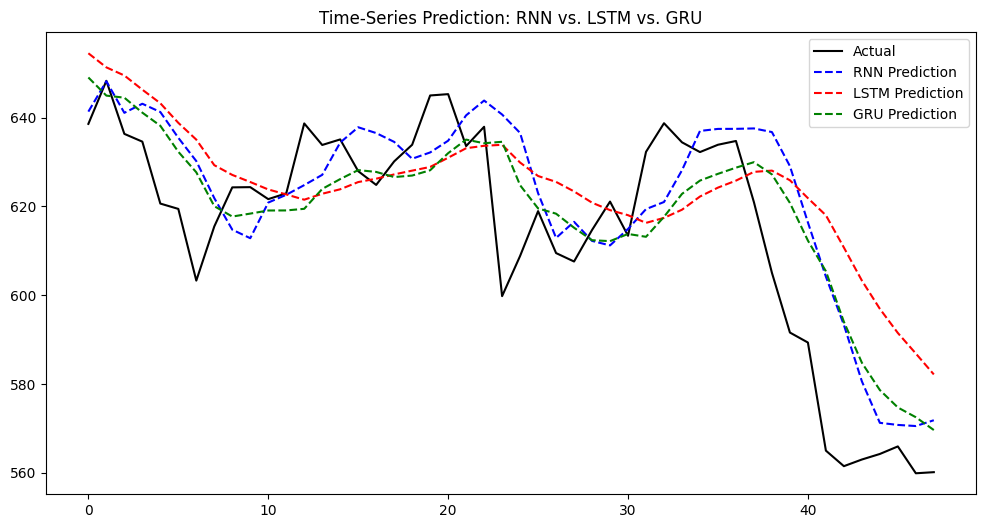

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual", color="black")
plt.plot(rnn_pred, label="RNN Prediction", linestyle="dashed", color="blue")
plt.plot(lstm_pred, label="LSTM Prediction", linestyle="dashed", color="red")
plt.plot(gru_pred, label="GRU Prediction", linestyle="dashed", color="green")
plt.legend()
plt.title("Time-Series Prediction: RNN vs. LSTM vs. GRU")
plt.show()